In [1]:
import itertools as it
import time
from utils import *

import numpy as np
from scipy import sparse

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.data import Data

import matplotlib.pyplot as plt


In [2]:
class GCN(torch.nn.Module):
    def __init__(self, node_features):
        super().__init__()
        # GCN initialization
        self.conv1 = GCNConv(node_features, 64)
        self.conv2 = GCNConv(64, 128)
        # self.conv1 = GATConv(node_features, 64, 5)
        # self.conv2 = GATConv(64 * 5, 128)
        # self.conv3 = GCNConv(128, 128)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.elu(x)
        # x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        # x = F.tanh(x)
        # x = self.conv3(x, edge_index)
        # x1^T * W * x2

        return x


(array([  0,   0,   0, ..., 181, 181, 181]), array([  2,   4,  14, ..., 135, 169, 178]))
tensor([[  0,   0,   0,  ..., 181, 181, 181],
        [  2,   4,  14,  ..., 135, 169, 178]])
[6. 6. 1. ... 2. 1. 3.]
histogram of original weight: (array([1516,  440,   80,   60,   14,   14]), array([1, 2, 3, 4, 5, 6, 7]))


/var/folders/qz/6jw6ywgd3bvdbjspv5vl39nm0000gn/T/ipykernel_96518/2491345088.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_croot-4qf3nw4h/pytorch_1648016051178/work/torch/csrc/utils/tensor_new.cpp:201.)
  edge_index = torch.tensor(lig_adjacency_matrix.nonzero(), dtype=torch.long)


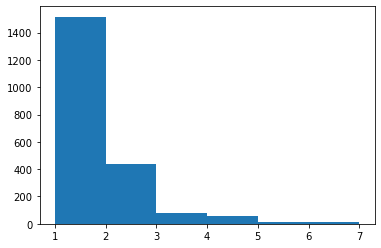

[6. 6. 1. ... 2. 1. 3.]


In [3]:
sat_path = './ssa2670-141.processed.cnf'
num_vars, num_clauses, sat_instance = read_sat(sat_path)

lig_adjacency_matrix, lig_weighted_adjacency_matrix = sat_to_lig_adjacency_matrix(sat_instance, num_vars)
print(lig_adjacency_matrix.nonzero())


# graph = nx.from_numpy_matrix(lig_adjacency_matrix)
# edges = nx.to_edgelist(graph)
# print(lig_adjacency_matrix.nonzero())

edge_index = torch.tensor(lig_adjacency_matrix.nonzero(), dtype=torch.long)
print(edge_index)
edge_value = lig_weighted_adjacency_matrix[lig_adjacency_matrix.nonzero()]
print(edge_value)
print(f'histogram of original weight: {np.histogram(edge_value, bins=[1, 2, 3, 4, 5, 6, 7])}')
plt.hist(edge_value, bins=[1, 2, 3, 4, 5, 6, 7])
plt.show()
# max_edge_value = max(edge_value)
# norm_edge_value = edge_value/max_edge_value
norm_edge_value = edge_value
print(norm_edge_value)

embeddings = torch.load('./embeddings.pt')
embeddings.requires_grad = False
# print(embeddings)
x = embeddings
data = Data(x=x, edge_index=edge_index)


In [4]:
# training
model = GCN(50)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    src, dst = edge_index
    score = (out[src] * out[dst]).sum(dim=-1)
    # score = torch.sigmoid(score)
    loss = F.mse_loss(score, torch.tensor(norm_edge_value, dtype=torch.float))
    loss.backward()
    optimizer.step()
    # print(f'epoch: {epoch}, loss: {loss.item()}')

out = model(data)
src, dst = edge_index
score = (out[src] * out[dst]).sum(dim=-1)
# print(min(score))
# score = torch.sigmoid(score)
print(f"norm_edge_value: {norm_edge_value}")
print(f"score: {score.detach()}")
print(f"min score: {min(score)}")
print(f"max score: {max(score)}")

norm_edge_value: [6. 6. 1. ... 2. 1. 3.]
score: tensor([4.5785, 5.5354, 0.4979,  ..., 1.8458, 2.1500, 2.9142])
min score: 0.3141999840736389
max score: 5.535421848297119


In [16]:
# CELL
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import scipy.sparse as sp
from scipy.sparse import load_npz

import torch

from cell.utils import link_prediction_performance
from cell.cell import Cell, EdgeOverlapCriterion, LinkPredictionCriterion
from cell.graph_statistics import compute_graph_statistics


sparse_matrix = sparse.csr_matrix(lig_adjacency_matrix)
cell_model = Cell(A=sparse_matrix,
             H=10,
             callbacks=[EdgeOverlapCriterion(invoke_every=10, edge_overlap_limit=.7)])


cell_model.train(steps=200,
            optimizer_fn=torch.optim.Adam,
            optimizer_args={'lr': 0.1,
                            'weight_decay': 1e-7})


Step:  10/200 Loss: 3.92292 Edge-Overlap: 0.407 Total-Time: 0
Step:  20/200 Loss: 3.30754 Edge-Overlap: 0.594 Total-Time: 0
Step:  30/200 Loss: 3.05353 Edge-Overlap: 0.653 Total-Time: 0
Step:  40/200 Loss: 2.91732 Edge-Overlap: 0.716 Total-Time: 0


In [17]:
generated_graph = cell_model.sample_graph()
graph_prime = generated_graph.A
graph_prime = graph_post_process(graph_prime)
# print(len(graph_prime))
# print(graph_prime)
# print(graph_prime[[0, 1, 2], [0, 0, 0]])

edge_index_prime = torch.tensor(graph_prime.nonzero(), dtype=torch.long)
data_prime = Data(x=x, edge_index = edge_index_prime)
out = model(data_prime)
src, dst = edge_index_prime
score = (out[src] * out[dst]).sum(dim=-1)
weight = score.detach().numpy()
weight[weight <= 1] = 1
weight = np.rint(weight).astype(int)
# print(f'histogram of inference weight: {np.histogram(weight, bins=[1, 2, 3, 4, 5, 6, 7])}')
# plt.hist(weight, bins=[1, 2, 3, 4, 5, 6, 7])

weighted_graph_prime = graph_prime
weighted_graph_prime[weighted_graph_prime.nonzero()] = weight
# lig_adjacency_matrix, lig_weighted_adjacency_matrix = sat_to_lig_adjacency_matrix(sat_instance, num_vars)
max_len = 8
clique_candidates = get_clique_candidates(graph_prime, max_len)
num_clauses = 377
num_vars = 91
print(weighted_graph_prime.shape)
current_clique_idxs = lazy_clique_edge_cover(weighted_graph_prime, clique_candidates, num_clauses, num_vars)
current_cliques = [clique_candidates[idx] for idx in current_clique_idxs]
current_sat = cliques_to_sat(current_cliques)

(182, 182)


In [18]:
generate_num = 50

start_time = time.time()
for idx in range(generate_num):
    # print(idx)
    generated_graph = cell_model.sample_graph()
    graph_prime = generated_graph.A
    graph_prime = graph_post_process(graph_prime)
    # print(len(graph_prime))
    # print(graph_prime)
    # print(graph_prime[[0, 1, 2], [0, 0, 0]])

    edge_index_prime = torch.tensor(graph_prime.nonzero(), dtype=torch.long)
    data_prime = Data(x=x, edge_index = edge_index_prime)
    out = model(data_prime)
    src, dst = edge_index_prime
    score = (out[src] * out[dst]).sum(dim=-1)
    weight = score.detach().numpy()
    weight[weight <= 1] = 1
    weight = np.rint(weight).astype(int)
    # print(f'histogram of inference weight: {np.histogram(weight, bins=[1, 2, 3, 4, 5, 6, 7])}')
    # plt.hist(weight, bins=[1, 2, 3, 4, 5, 6, 7])

    weighted_graph_prime = graph_prime
    weighted_graph_prime[weighted_graph_prime.nonzero()] = weight
    # lig_adjacency_matrix, lig_weighted_adjacency_matrix = sat_to_lig_adjacency_matrix(sat_instance, num_vars)
    max_len = 8
    clique_candidates = get_clique_candidates(graph_prime, max_len)
    num_clauses = 377
    num_vars = 91
    # print(weighted_graph_prime.shape)
    current_clique_idxs = lazy_clique_edge_cover(weighted_graph_prime, clique_candidates, num_clauses, num_vars)
    current_cliques = [clique_candidates[idx] for idx in current_clique_idxs]
    current_sat = cliques_to_sat(current_cliques)

    path = f"./eval_formulas/ssa2670-141/generating-sat-{idx}.cnf"
    with open(path, 'w') as f:
        f.write('p cnf 91 377\n')
        for clause in current_sat:
            f.write(f"{' '.join([str(v) for v in clause])} 0\n")

print(f'generating {generate_num} instances with time {time.time() - start_time}')

generating 50 instances with time 3.259002208709717


In [7]:
features = [
        "clu. VIG",
        "clu. LIG",
        "mod. VIG",
        "mod. LIG",
        "mod. VCG",
        "mod. LCG"
]

metrics = eval_solution(current_sat, num_vars)
for feature, value in zip(features, metrics):
    print(f'{feature}: {value}')

clu. VIG: 0.4731028752283812
clu. LIG: 0.3008281581447045
mod. VIG: 0.4939167184045137
mod. LIG: 0.5549594736978142
mod. VCG: 0.6437184756340264
mod. LCG: 0.5227524038461538


# Todo

- Optimize the optimal weighted coverage (OWC) algorithm
- Generate more graph for the ssa2670, compute the average metric
- Test the method on more instances
- *Test the solver performance*